In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse

In [6]:
import utilitis_FEEC.bsplines       as bsp
import utilitis_FEEC.projectors_mhd as mhd
import utilitis_FEEC.projectors     as proj
import utilitis_FEEC.derivatives    as der
import utilitis_FEEC.evaluation     as eva

import utilitis_FEEC.mass_matrices  as mass
import utilitis_FEEC.mappings       as maps

In [3]:
import utilitis_PIC.ECHO_fields
import utilitis_PIC.ECHO_pusher
import utilitis_PIC.ECHO_accumulation

In [5]:
#====================================================================================
#  calling epyccel for particle pusher
#====================================================================================
from pyccel.epyccel import epyccel

pic_fields = epyccel(utilitis_PIC.ECHO_fields)
pic_pusher = epyccel(utilitis_PIC.ECHO_pusher)
pic_accumu = epyccel(utilitis_PIC.ECHO_accumulation)

print('pyccelization done!')
#====================================================================================

pyccelization done!


In [121]:
Nel = [3, 3, 32]           # mesh generation on logical domain
bc  = [True, True, True]   # boundary conditions
p   = [2, 2, 2]            # splines degrees  
L   = [1., 1., 2*np.pi]    # box lengthes of physical domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors
t         = [T[1:-1] for T in T]                                               # reduced knot vectors
Nbase0    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions in V0
Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]                        # TODO delte this later
Ntot      = Nbase0[0] *Nbase0[1]*Nbase0[2]                                     # total number of basis functions



# geometry
DF      = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])
DFinv   = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])

G       = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])
Ginv    = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])

g_sqrt  = L[0]*L[1]*L[2]

mapping = maps.mappings(['slab', L[0], L[1], L[2]]) 

# time step
dt = 0.05

#=================== coefficients for pp-forms (1 - component) ======================
if p[0] == 3:
    d1 = 1/Nel[0]
    pp0_1 = np.asfortranarray([[1/6, -1/(2*d1), 1/(2*d1**2), -1/(6*d1**3)], [2/3, 0., -1/d1**2, 1/(2*d1**3)], [1/6, 1/(2*d1), 1/(2*d1**2), -1/(2*d1**3)], [0., 0., 0., 1/(6*d1**3)]])
    pp1_1 = np.asfortranarray([[1/2, -1/d1, 1/(2*d1**2)], [1/2, 1/d1, -1/d1**2], [0., 0., 1/(2*d1**2)]])/d1
elif p[0] == 2:
    d1 = 1/Nel[0]
    pp0_1 = np.asfortranarray([[1/2, -1/d1, 1/(2*d1**2)], [1/2, 1/d1, -1/d1**2], [0., 0., 1/(2*d1**2)]])
    pp1_1 = np.asfortranarray([[1., -1/d1], [0., 1/d1]])/d1
else:
    print('Only cubic and quadratic splines implemented!')
#====================================================================================



#=================== coefficients for pp-forms (2 - component) ======================
if p[1] == 3:
    d2 = 1/Nel[1]
    pp0_2 = np.asfortranarray([[1/6, -1/(2*d2), 1/(2*d2**2), -1/(6*d2**3)], [2/3, 0., -1/d2**2, 1/(2*d2**3)], [1/6, 1/(2*d2), 1/(2*d2**2), -1/(2*d2**3)], [0., 0., 0., 1/(6*d2**3)]])
    pp1_2 = np.asfortranarray([[1/2, -1/d2, 1/(2*d2**2)], [1/2, 1/d2, -1/d2**2], [0., 0., 1/(2*d2**2)]])/d2
elif p[1] == 2:
    d2 = 1/Nel[1]
    pp0_2 = np.asfortranarray([[1/2, -1/d2, 1/(2*d2**2)], [1/2, 1/d2, -1/d2**2], [0., 0., 1/(2*d2**2)]])
    pp1_2 = np.asfortranarray([[1., -1/d2], [0., 1/d2]])/d2
else:
    print('Only cubic and quadratic splines implemented!')
#====================================================================================



#=================== coefficients for pp-forms (3 - component) ======================
if p[2] == 3:
    d3 = 1/Nel[2]
    pp0_3 = np.asfortranarray([[1/6, -1/(2*d3), 1/(2*d3**2), -1/(6*d3**3)], [2/3, 0., -1/d3**2, 1/(2*d3**3)], [1/6, 1/(2*d3), 1/(2*d3**2), -1/(2*d3**3)], [0., 0., 0., 1/(6*d3**3)]])
    pp1_3 = np.asfortranarray([[1/2, -1/d3, 1/(2*d3**2)], [1/2, 1/d3, -1/d3**2], [0., 0., 1/(2*d3**2)]])/d3
elif p[2] == 2:
    d3 = 1/Nel[2]
    pp0_3 = np.asfortranarray([[1/2, -1/d3, 1/(2*d3**2)], [1/2, 1/d3, -1/d3**2], [0., 0., 1/(2*d3**2)]])
    pp1_3 = np.asfortranarray([[1., -1/d3], [0., 1/d3]])/d3
else:
    print('Only cubic and quadratic splines implemented!')
#====================================================================================

In [122]:
Ueq_phys = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq      = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys = np.array([0., 0., 1.])     # background magnetic field (vector/2-form on physical domain)
Beq      = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)



B0_23    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (0.)
B0_31    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0.)   
B0_12    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (1.)   

B0_hat   = [B0_23, B0_31, B0_12]

rho0_123 = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * (1.)


# initial conditions
k   = 1.
amp = 1e-4


B1_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (amp * np.sin(k * q3 *L[2]))
B2_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
B3_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0. * q1)

U1_ini = lambda q1, q2, q3 : mapping.DF[0][0](q1, q2, q3) * (0. * q1)
U2_ini = lambda q1, q2, q3 : mapping.DF[1][1](q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
U3_ini = lambda q1, q2, q3 : mapping.DF[2][2](q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0. * q2)

In [123]:
# reserve memory for unknowns
b1, b2, b3 = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)
u1, u2, u3 = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)

mat11 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat12 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat13 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

mat22 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat23 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat33 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

vec1  = np.zeros((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec2  = np.zeros((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec3  = np.zeros((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

In [124]:
PRO = proj.projectors_3d(p, Nbase_old, T, bc)

# left-hand sides of projectors
PRO.assemble_V1()
PRO.assemble_V2()

# projection of initial conditions
b1[:], b2[:], b3[:] = PRO.PI_2([B1_ini, B2_ini, B3_ini])
u1[:], u2[:], u3[:] = PRO.PI_1([U1_ini, U2_ini, U3_ini])

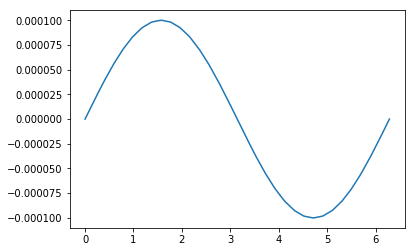

In [125]:
q1plot = np.array([0.5])
q2plot = np.array([0.5])
q3plot = np.linspace(0., 1., 200)

test1, test2, test3 = eva.FEM_field_V2_3d([b1, b2, b3], [q1plot, q2plot, q3plot], T, p, bc)

plt.plot(q3plot*L[2], 1/g_sqrt*DF[0, 0]*test1)

In [164]:
MHD = mhd.projections_mhd(p, Nbase_proj, T, bc)

# right-hand side of projection matrices
W1, W2, W3 = MHD.projection_W(rho0_123, mapping.g_sqrt)
TAU1, TAU2, TAU3 = MHD.projection_T(B0_hat, mapping.Ginv)

# mass matrices in V0, V1 and V2
M1 = mass.mass_V1(T, p, bc, mapping.Ginv, mapping.g_sqrt)
M2 = mass.mass_V2(T, p, bc, mapping.G, mapping.g_sqrt)

# discrete curl
derivatives = der.discrete_derivatives(p, T, bc)

CURL = derivatives.CURL_3d(T, p, bc)

# perform projections of T1, T2, T3
TAU1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, TAU1)
TAU2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, TAU2)
TAU3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, TAU3)

TAU = sparse.bmat([[TAU1], [TAU2], [TAU3]], format='csc')

# perform projections of W1, W2, W3
W1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, W1)
W2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, W2)
W3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, W3)

W = sparse.bmat([[W1, None, None], [None, W2, None], [None, None, W3]], format='csc')

# compute matrix A 
A = 1/2*(M1.dot(W) + W.T.dot(M1))

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

A = A.toarray()

In [165]:
Np = int(1e5)

particles       = np.empty((Np, 7), dtype=float, order='F')

particles[:, 0] = np.random.rand(Np)
particles[:, 1] = np.random.rand(Np)
particles[:, 2] = np.random.rand(Np)

vth = 1.
v0  = 2.
nuh = 5e-2
nh  = (1.) * nuh

particles[:, 3] = np.random.randn(Np)*vth/np.sqrt(2)
particles[:, 4] = np.random.randn(Np)*vth/np.sqrt(2)
particles[:, 5] = np.random.randn(Np)*vth/np.sqrt(2) + v0

particles[:, 6] = nh*L[0]*L[1]*L[2]/Np 

spans0       = np.empty((Np, 3), dtype=int, order='F')
spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]

# empty matrices for fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

In [166]:
# compute fields at particles
pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, b1.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), b2.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), b3.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), Beq, pp0_1, pp0_2, pp0_3, pp1_1, pp1_2, pp1_3, B_part)
pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, u1.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), u2.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), u3.reshape(Nbase0[0], Nbase0[1], Nbase0[2], order='F'), Ueq, pp0_1, pp0_2, pp0_3, pp1_1, pp1_2, pp1_3, U_part)

In [167]:
b = np.concatenate((b1, b2, b3))
u = np.concatenate((u1, u2, u3))

In [147]:
def update():
    
    # step1 
    pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot, order='C'), mat13.reshape(Ntot, Ntot, order='C')], [-mat12.reshape(Ntot, Ntot, order='C'), np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot, order='C')], [-mat13.reshape(Ntot, Ntot, order='C'), -mat23.reshape(Ntot, Ntot, order='C'), np.zeros((Ntot, Ntot))]])
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))

In [168]:
# step1 
pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)

AJ11A = np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot, order='C'), mat13.reshape(Ntot, Ntot, order='C')], [-mat12.reshape(Ntot, Ntot, order='C'), np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot, order='C')], [-mat13.reshape(Ntot, Ntot, order='C'), -mat23.reshape(Ntot, Ntot, order='C'), np.zeros((Ntot, Ntot))]])

MAT = A - dt/2*AJ11A
vec = (A + dt/2*AJ11A).dot(u)

In [176]:
test = np.linalg.solve(MAT, vec)

In [177]:
test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.